# Potato Disease Classification

### Import all the Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
print(tf.__version__)

2024-07-12 08:08:25.920080: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-12 08:08:27.013404: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-12 08:08:29.705611: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-12 08:08:37.406508: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.16.1


### Set all the Constants

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=30

### Import data into tensorflow dataset object

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [4]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 2 4 6 0 7 9 6 6 7 4 7 1 1 0 7 0 7 0 9 0 5 7 2 1 4 7 9 9 1 2 5]


2024-07-12 08:09:08.726997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Visualize some of the images from our dataset

2024-07-11 16:46:31.528228: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


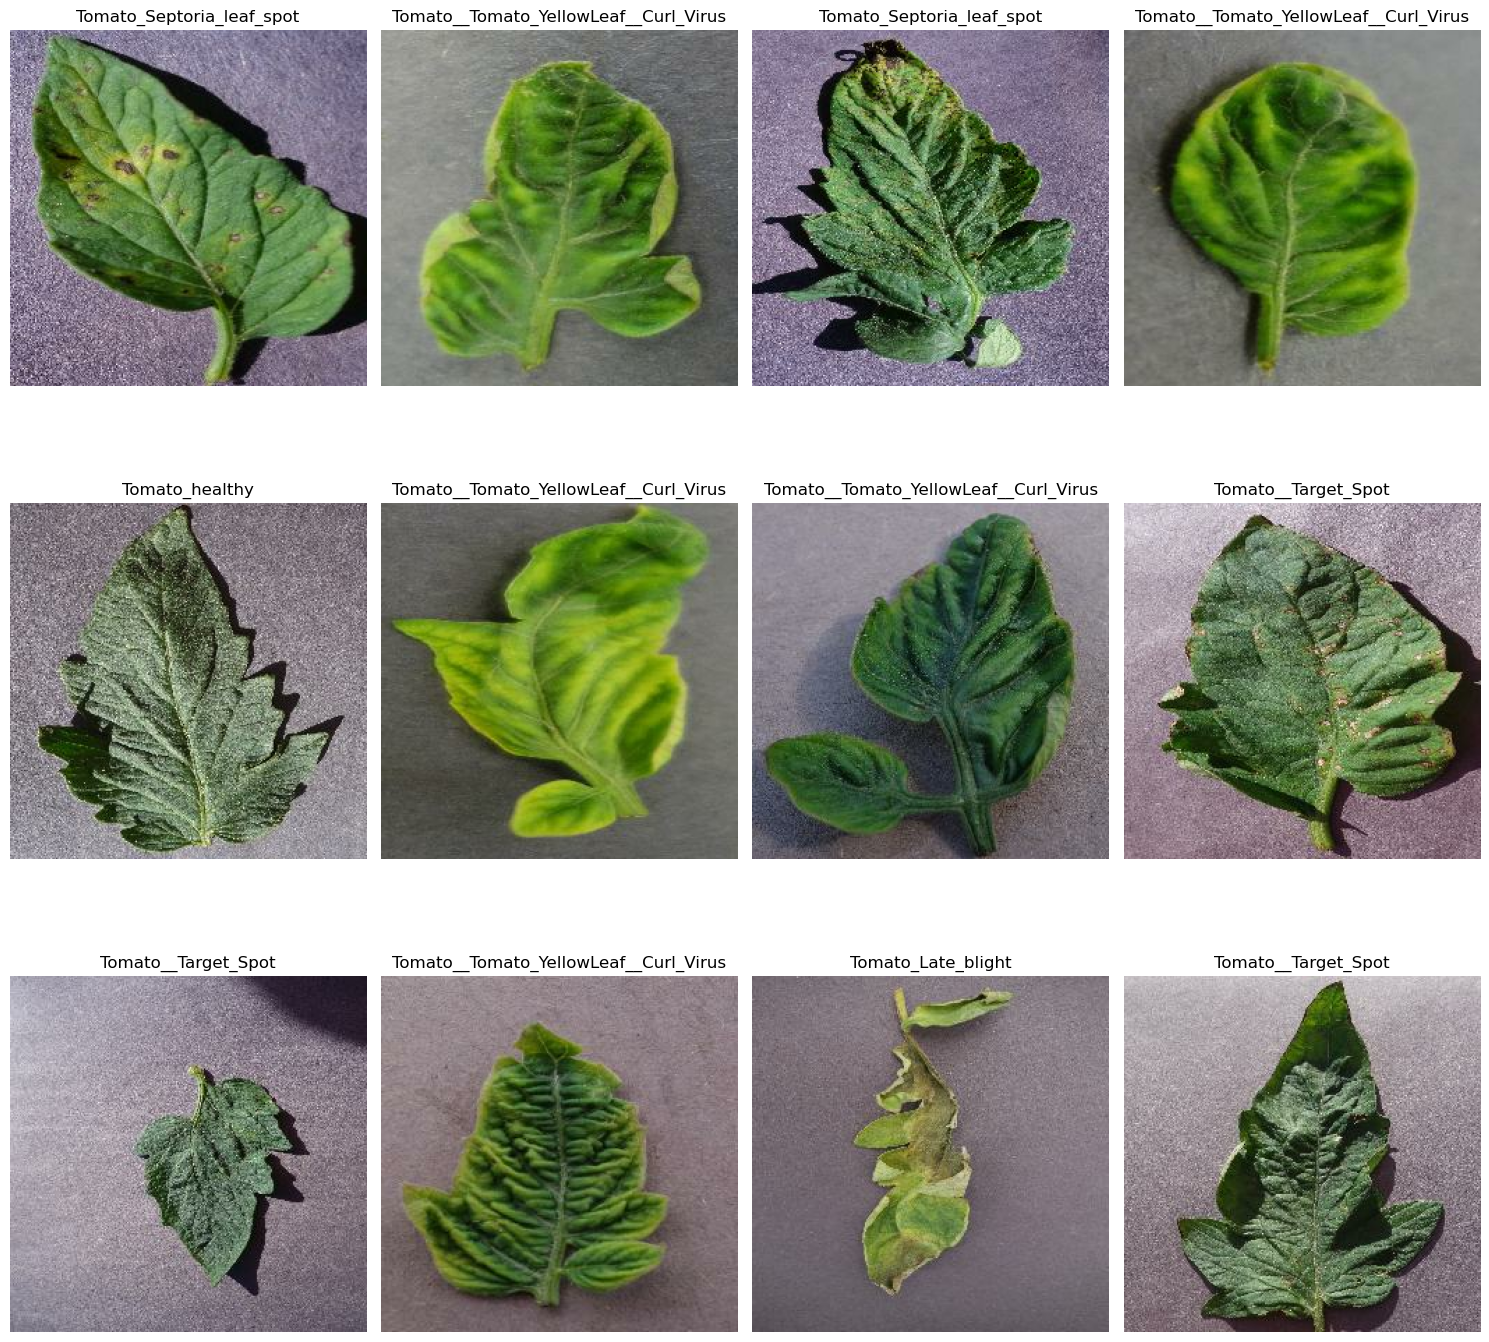

In [6]:
plt.figure(figsize=(15, 15))  
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]], fontsize=12)  
        plt.axis("off")
        
plt.tight_layout()  
plt.show()


### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [7]:
len(dataset)

501

In [8]:
train_size = 0.8
len(dataset)*train_size

400.8

In [9]:
train_ds = dataset.take(400)
len(train_ds)

400

In [10]:
test_ds = dataset.skip(400)
len(test_ds)

101

In [11]:
val_size=0.1
len(dataset)*val_size

50.1

In [12]:
val_ds = test_ds.take(50)
len(val_ds)

50

In [13]:
test_ds = test_ds.skip(50)
len(test_ds)

51

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

400

In [17]:
len(val_ds)

50

In [18]:
len(test_ds)

51

### Cache, Shuffle, and Prefetch the Dataset

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

/home/tibebe/anaconda3/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 10)               │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,202 (719.54 KB)

 Trainable params: 184,202 (719.54 KB)

 Non-trainable params: 0 (0.00 B)

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/30


2024-07-11 16:47:00.047390: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 54 of 10000
2024-07-11 16:47:10.156980: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 102 of 10000
2024-07-11 16:47:30.034985: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 202 of 10000
2024-07-11 16:47:40.038295: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 252 of 10000
2024-07-11 16:47:50.169264: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 302 of 10000
2024-07-11 16:48:10.212096: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:15: Filling up shuffle buffer (this may tak

387/400 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.2875 - loss: 1.9631

In [ ]:
scores = model.evaluate(test_ds)

In [ ]:
scores

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [ ]:
history

In [ ]:
history.params

In [ ]:
history.history.keys()

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [ ]:
type(history.history['loss'])

In [ ]:
len(history.history['loss'])

In [ ]:
history.history['loss'][:5] # show loss for first 5 epochs

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### Saving the Model
We append the model to the list of models as a new version

In [ ]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

In [ ]:
model.save("../model.keras")